In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import act_max_util as amu

from autoencoder import *
from solver import *
from model_utils import *

%load_ext autoreload
%autoreload 2

### Activation Maximization

In [2]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

In [3]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32]

### RFA For Every Neuron For Different Models

In [16]:
data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

sae = load_model(f'/home/david/mnist_model/sae/5', 'sae', 59)
dae = load_model(f'/home/david/mnist_model/dae/5', 'dae', 59)

layer_name = 'bottle_neck'
sae_activation_dictionary = {}
dae_activation_dictionary = {}

sae.encoder.activation_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))
dae.encoder.activation_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

sae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=sae,
                    input=input,
                    layer_activation=sae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    sae_rf_ls.append(output.detach().numpy())

dae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=dae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

sae_rf_ls = np.array(sae_rf_ls).squeeze()
dae_rf_ls = np.array(dae_rf_ls).squeeze()

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

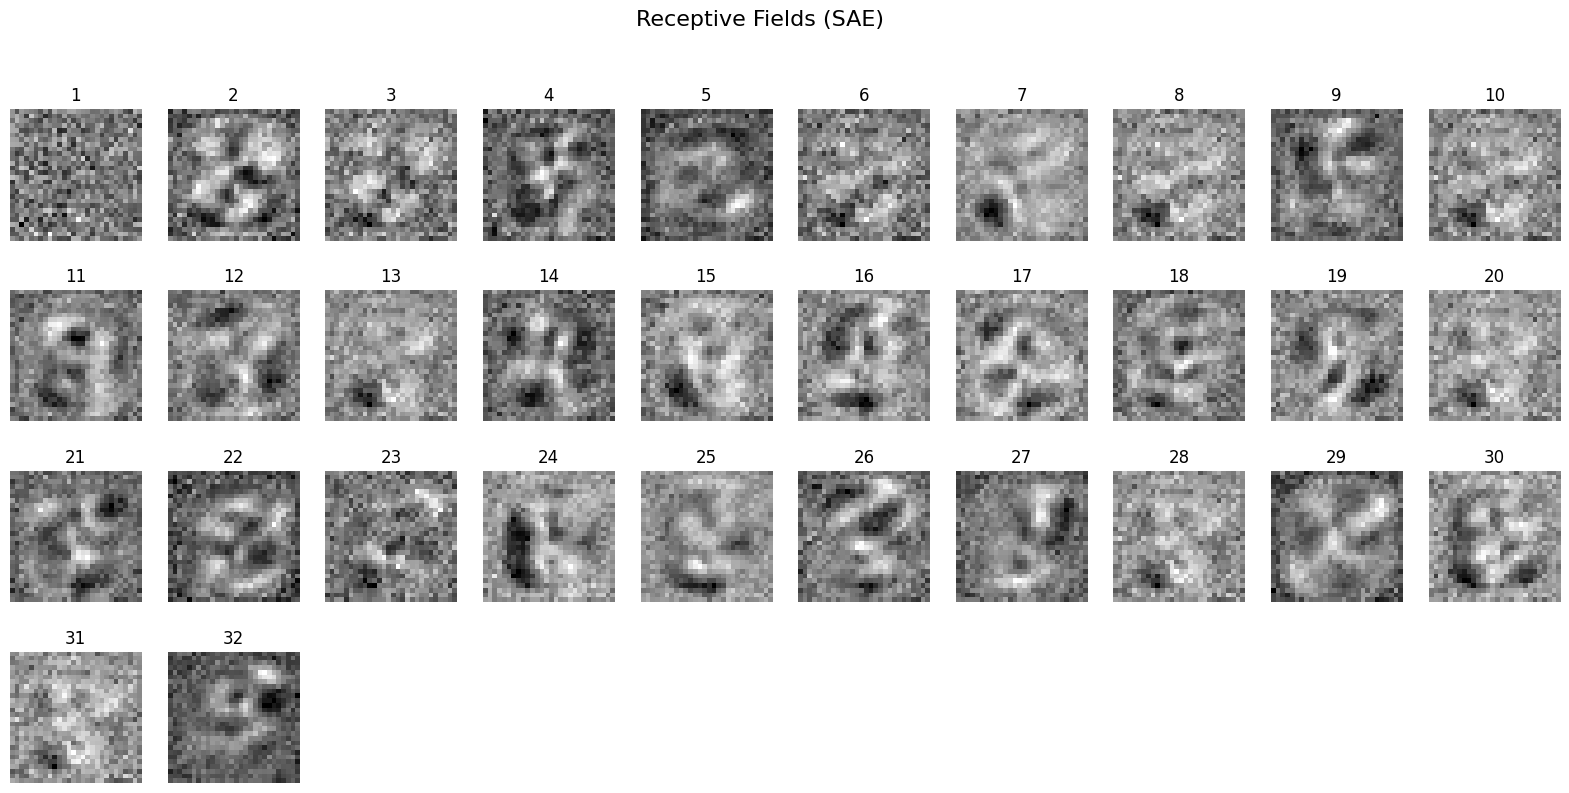

In [17]:
fig = plt.figure(figsize=(20,9))
fig.suptitle("Receptive Fields (SAE)", fontsize=16)
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.axis('off')
    plt.imshow(sae_rf_ls[i].reshape(28,28),cmap='gray')

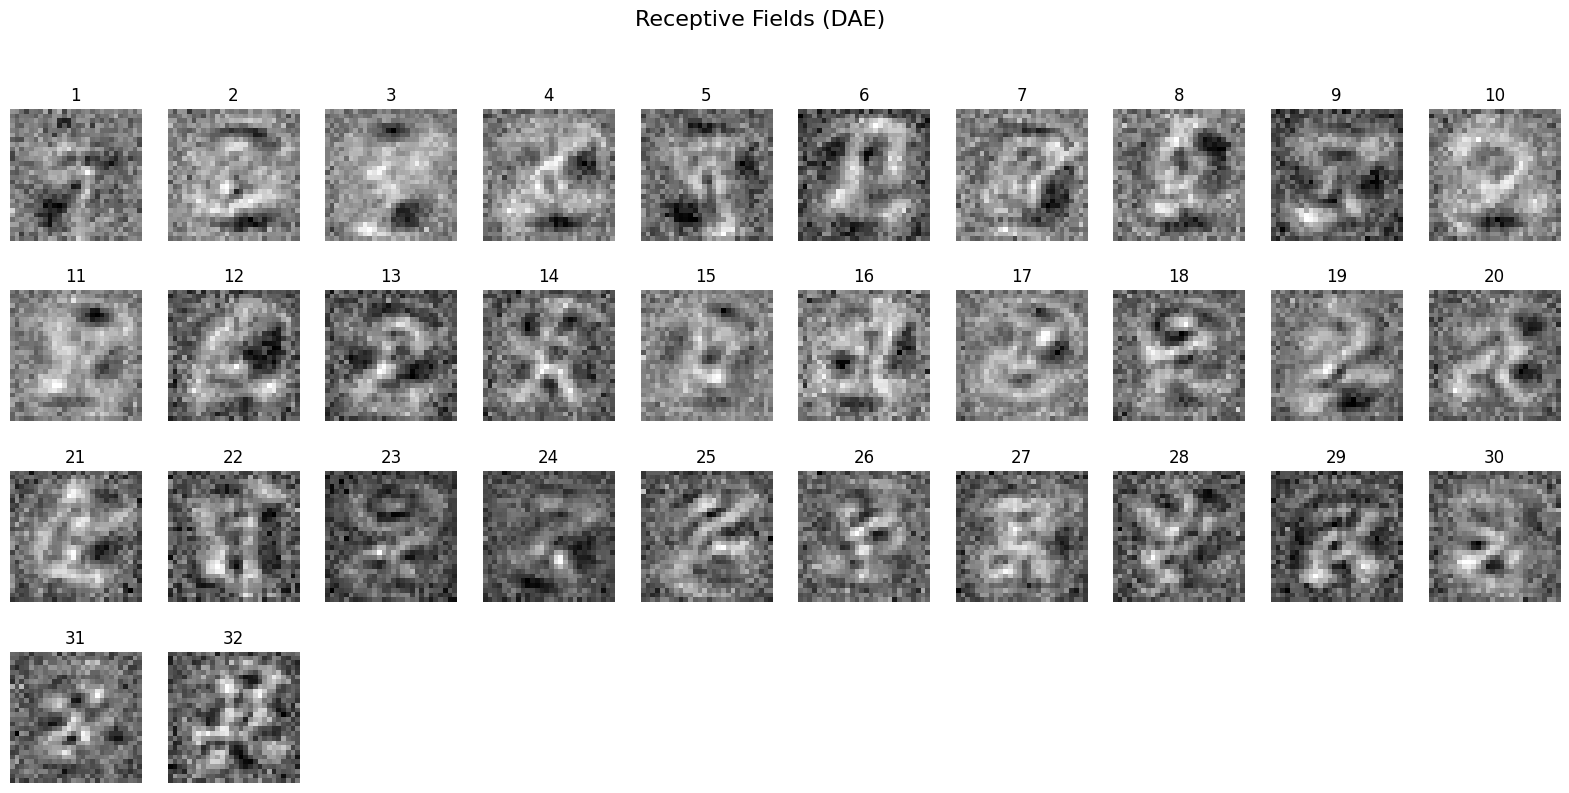

In [15]:
fig = plt.figure(figsize=(20,9))
fig.suptitle("Receptive Fields (DAE)", fontsize=16)
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.axis('off')
    plt.imshow(dae_rf_ls[i].reshape(28,28),cmap='gray')

In [107]:
# For all different models
sae_rf_matrices = []
dae_rf_matrices = []

for iteration in tqdm(range(5)):
    # For all different epochs
    sae_rf_matrix = []
    dae_rf_matrix = []
    
    for epoch in range(60):
        data = torch.randn(28, 28)
        data = data.unsqueeze(0)
        input = data.view(data.size(0), -1)
        input.requires_grad_(True)

        sae = load_model(f'/home/david/mnist_model/sae/{iteration}', 'sae', epoch)
        dae = load_model(f'/home/david/mnist_model/dae/{iteration}', 'dae', epoch)
        
        layer_name = 'bottle_neck'
        sae_activation_dictionary = {}
        dae_activation_dictionary = {}

        sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))
        dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

        sae_rf_ls = []
        for i in range(32):
            output = amu.act_max(network=sae,
                            input=input,
                            layer_activation=sae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            sae_rf_ls.append(output.detach().numpy())
        sae_rf_ls = np.array(sae_rf_ls).squeeze()

        dae_rf_ls = []
        for i in range(size_ls[epoch]):
            output = amu.act_max(network=dae,
                            input=input,
                            layer_activation=dae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            dae_rf_ls.append(output.detach().numpy())
        dae_rf_ls = np.array(dae_rf_ls).squeeze()

        sae_rf_matrix.append(sae_rf_ls)
        dae_rf_matrix.append(dae_rf_ls)

    sae_rf_matrices.append(sae_rf_matrix)
    dae_rf_matrices.append(dae_rf_matrix)

100%|██████████| 5/5 [1:20:17<00:00, 963.58s/it] 


In [26]:
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

5 Model

50 Epochs

4 - 32 Neurons

784 Pixels

In [92]:
def pad_matrices(model_ls, target_dim=32):
    padded_data = []
    for epoch_ls in model_ls:
        padded_epoch_ls = []
        for neuron_ls in epoch_ls:
            padding_array = np.zeros((target_dim - len(neuron_ls), 784))
            padded_neuron_ls = np.vstack([neuron_ls, padding_array])
            padded_epoch_ls.append(padded_neuron_ls)
        padded_data.append(padded_epoch_ls)
    return np.array(padded_data)

In [108]:
sae_rf_matrices = np.array(sae_rf_matrices)
sae_rf_matrices.shape

(5, 60, 32, 784)

In [109]:
dae_rf_matrices = pad_matrices(dae_rf_matrices)
dae_rf_matrices.shape

(5, 60, 32, 784)

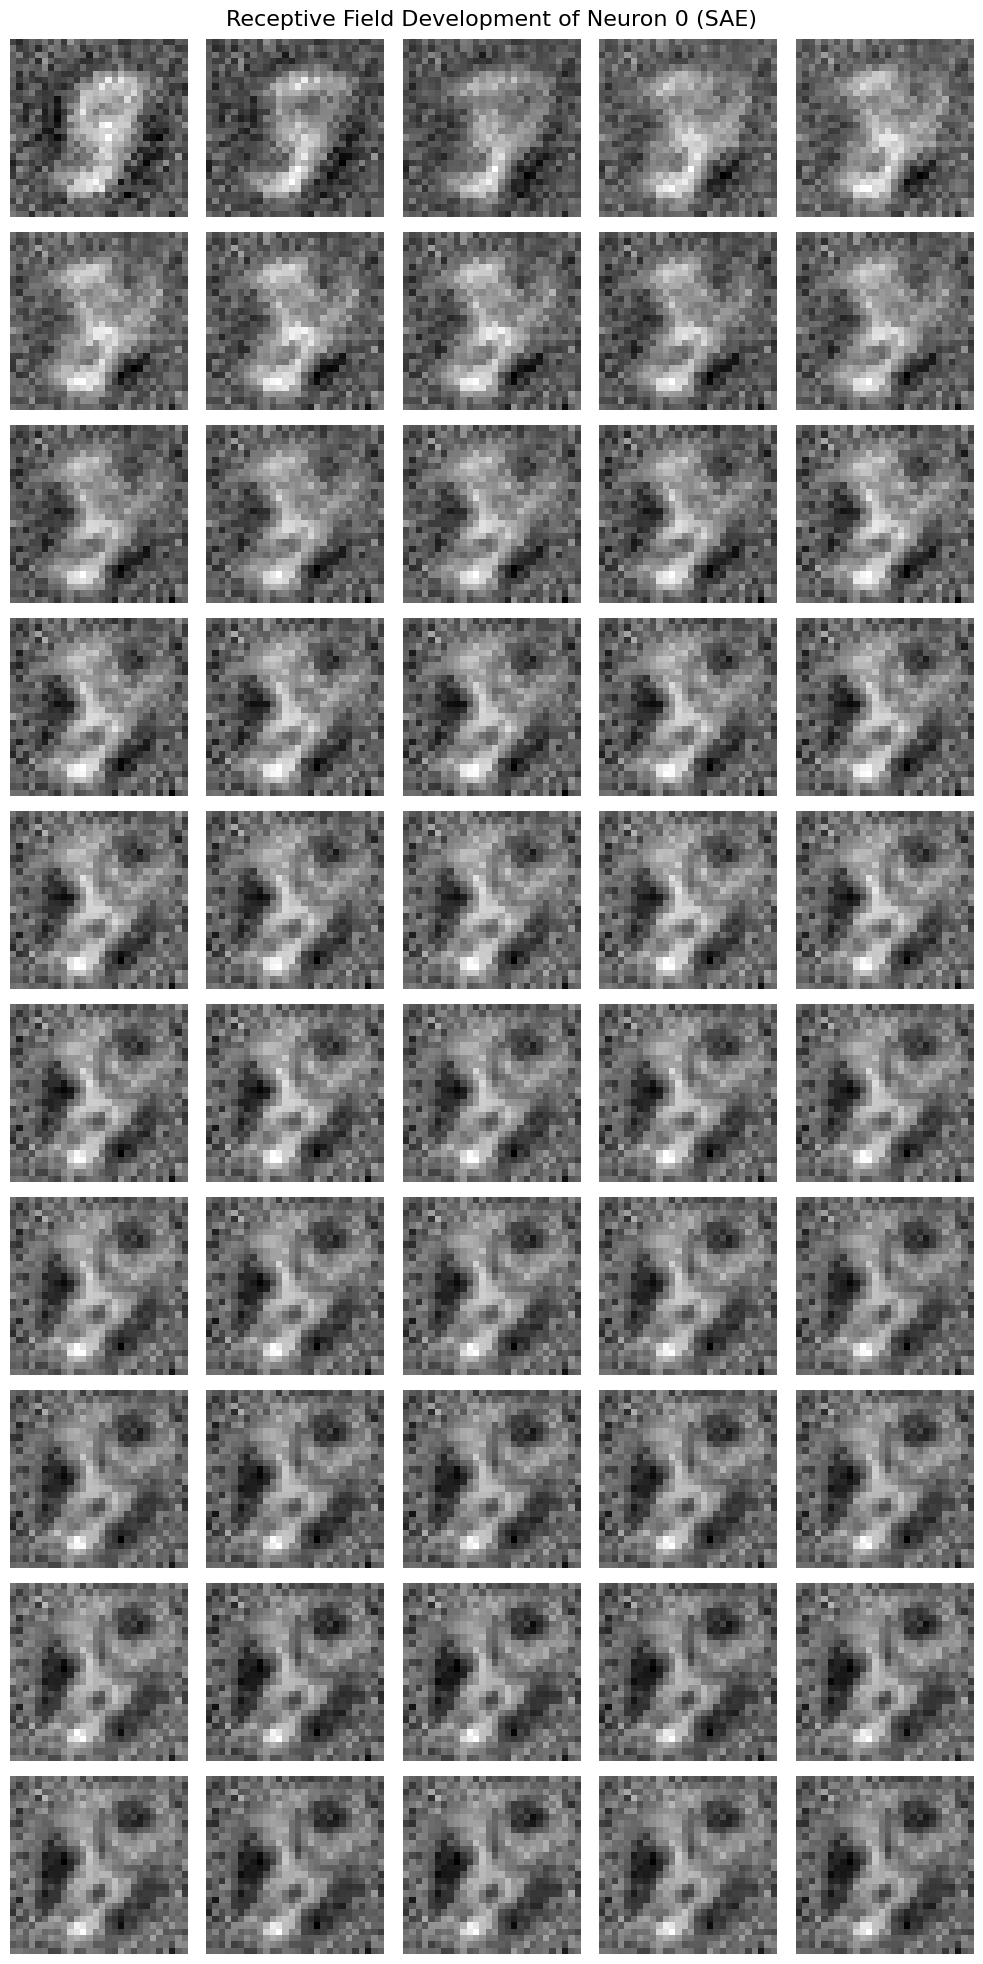

In [110]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(sae_rf_matrices[0][i][0].reshape(28, 28), cmap='binary_r')
    axes[i].axis('off')

fig.suptitle("Receptive Field Development of Neuron 0 (SAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

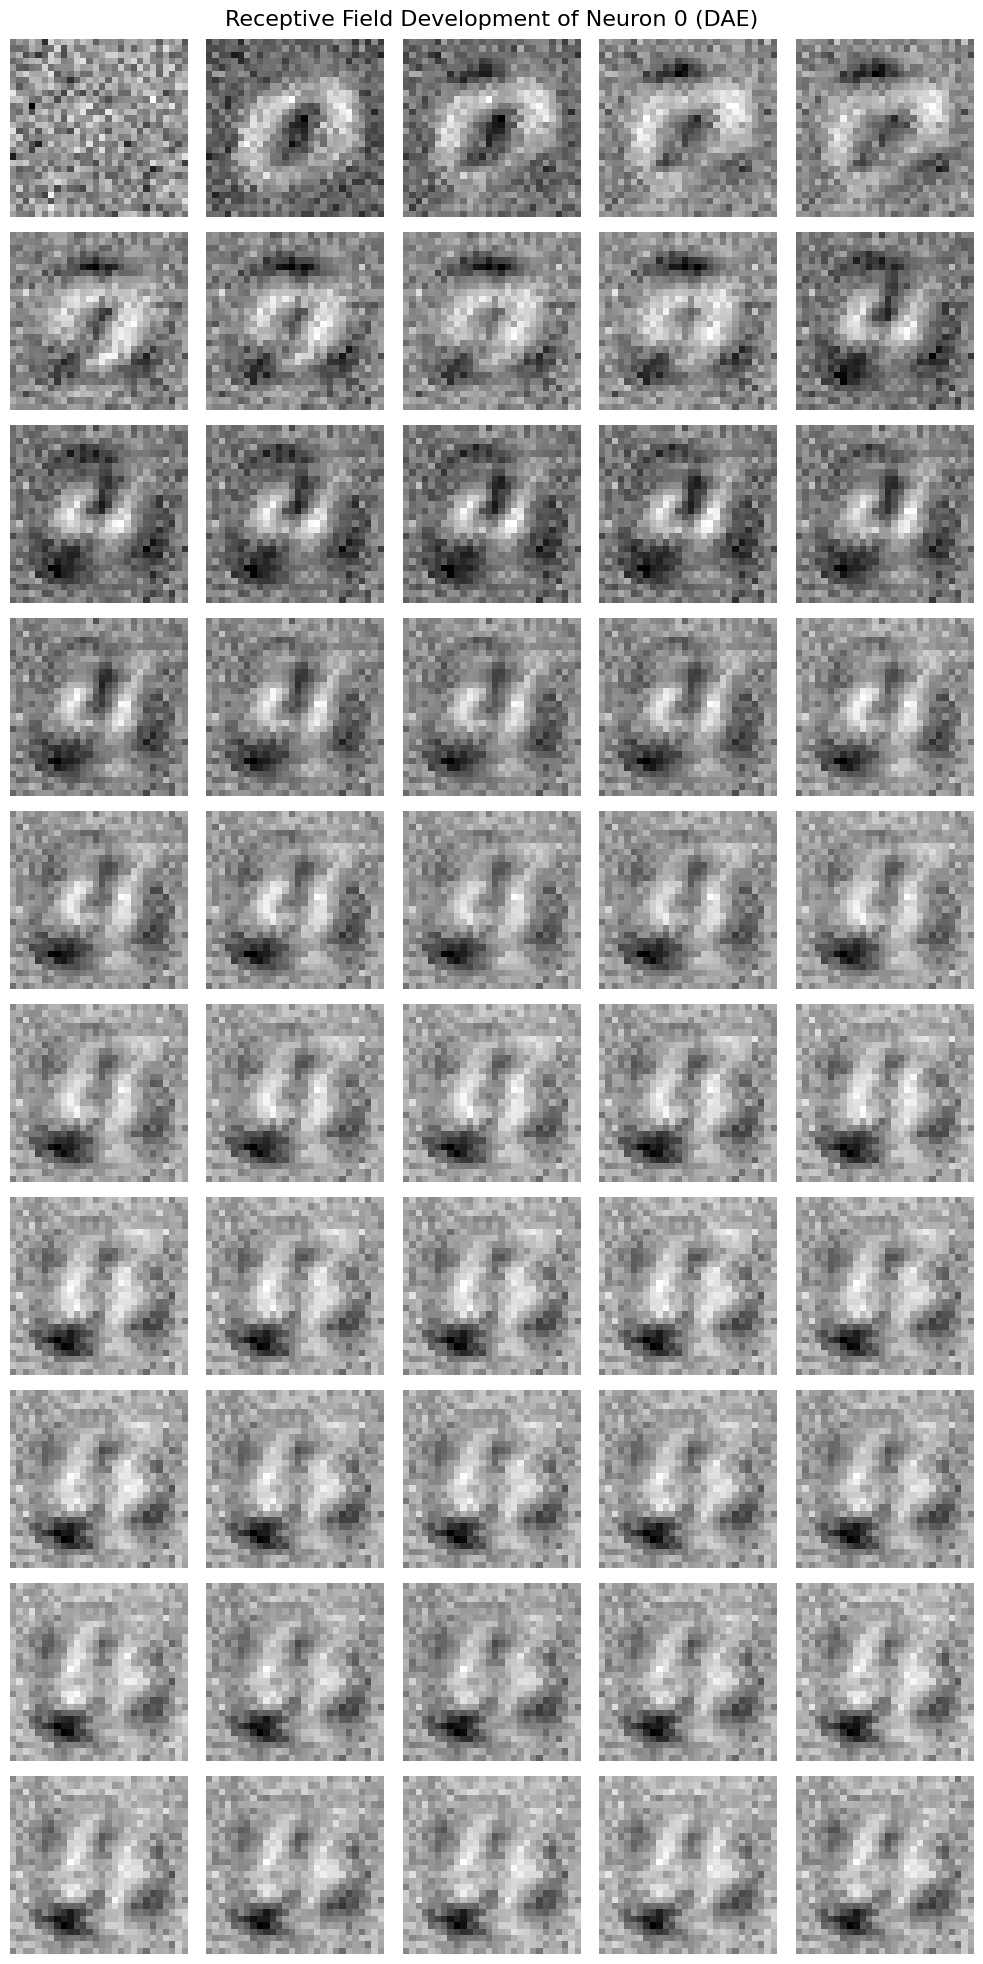

In [111]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(dae_rf_matrices[0][i][0].reshape(28, 28), cmap='binary_r')
    axes[i].axis('off')

fig.suptitle("Receptive Field Development of Neuron 0 (DAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In [ ]:
num_models = 5
num_epochs = 60
num_neurons = 32

sae_angles_matrix = np.zeros((num_models, num_neurons, num_epochs-1))
dae_angles_matrix = np.zeros((num_models, num_neurons, num_epochs-1))

for model in range(num_models):
    for epoch in range(num_epochs-1):
        for neuron in range(num_neurons):
            angle = cosine_angle_between_pcs(dae_rf_matrices[model][epoch][neuron], dae_rf_matrices[model][epoch + 1][neuron])
            dae_angles_matrix[model, neuron, epoch] = angle
            angle = cosine_angle_between_pcs(sae_rf_matrices[model][epoch][neuron], sae_rf_matrices[model][epoch + 1][neuron])
            sae_angles_matrix[model, neuron, epoch] = angle

sae_angles_matrix = np.array(sae_angles_matrix)
dae_angles_matrix = np.array(dae_angles_matrix)

sae_average_angles = np.mean(sae_angles_matrix, axis=0)
dae_average_angles = np.mean(dae_angles_matrix, axis=0)

Shape of angles array: (5, 32, 59)


/tmp/ipykernel_6009/575378270.py:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [ ]:
# np.save("Saved_Results/sae_average_angles.npy", sae_average_angles)
# np.save("Saved_Results/dae_average_angles.npy", dae_average_angles)

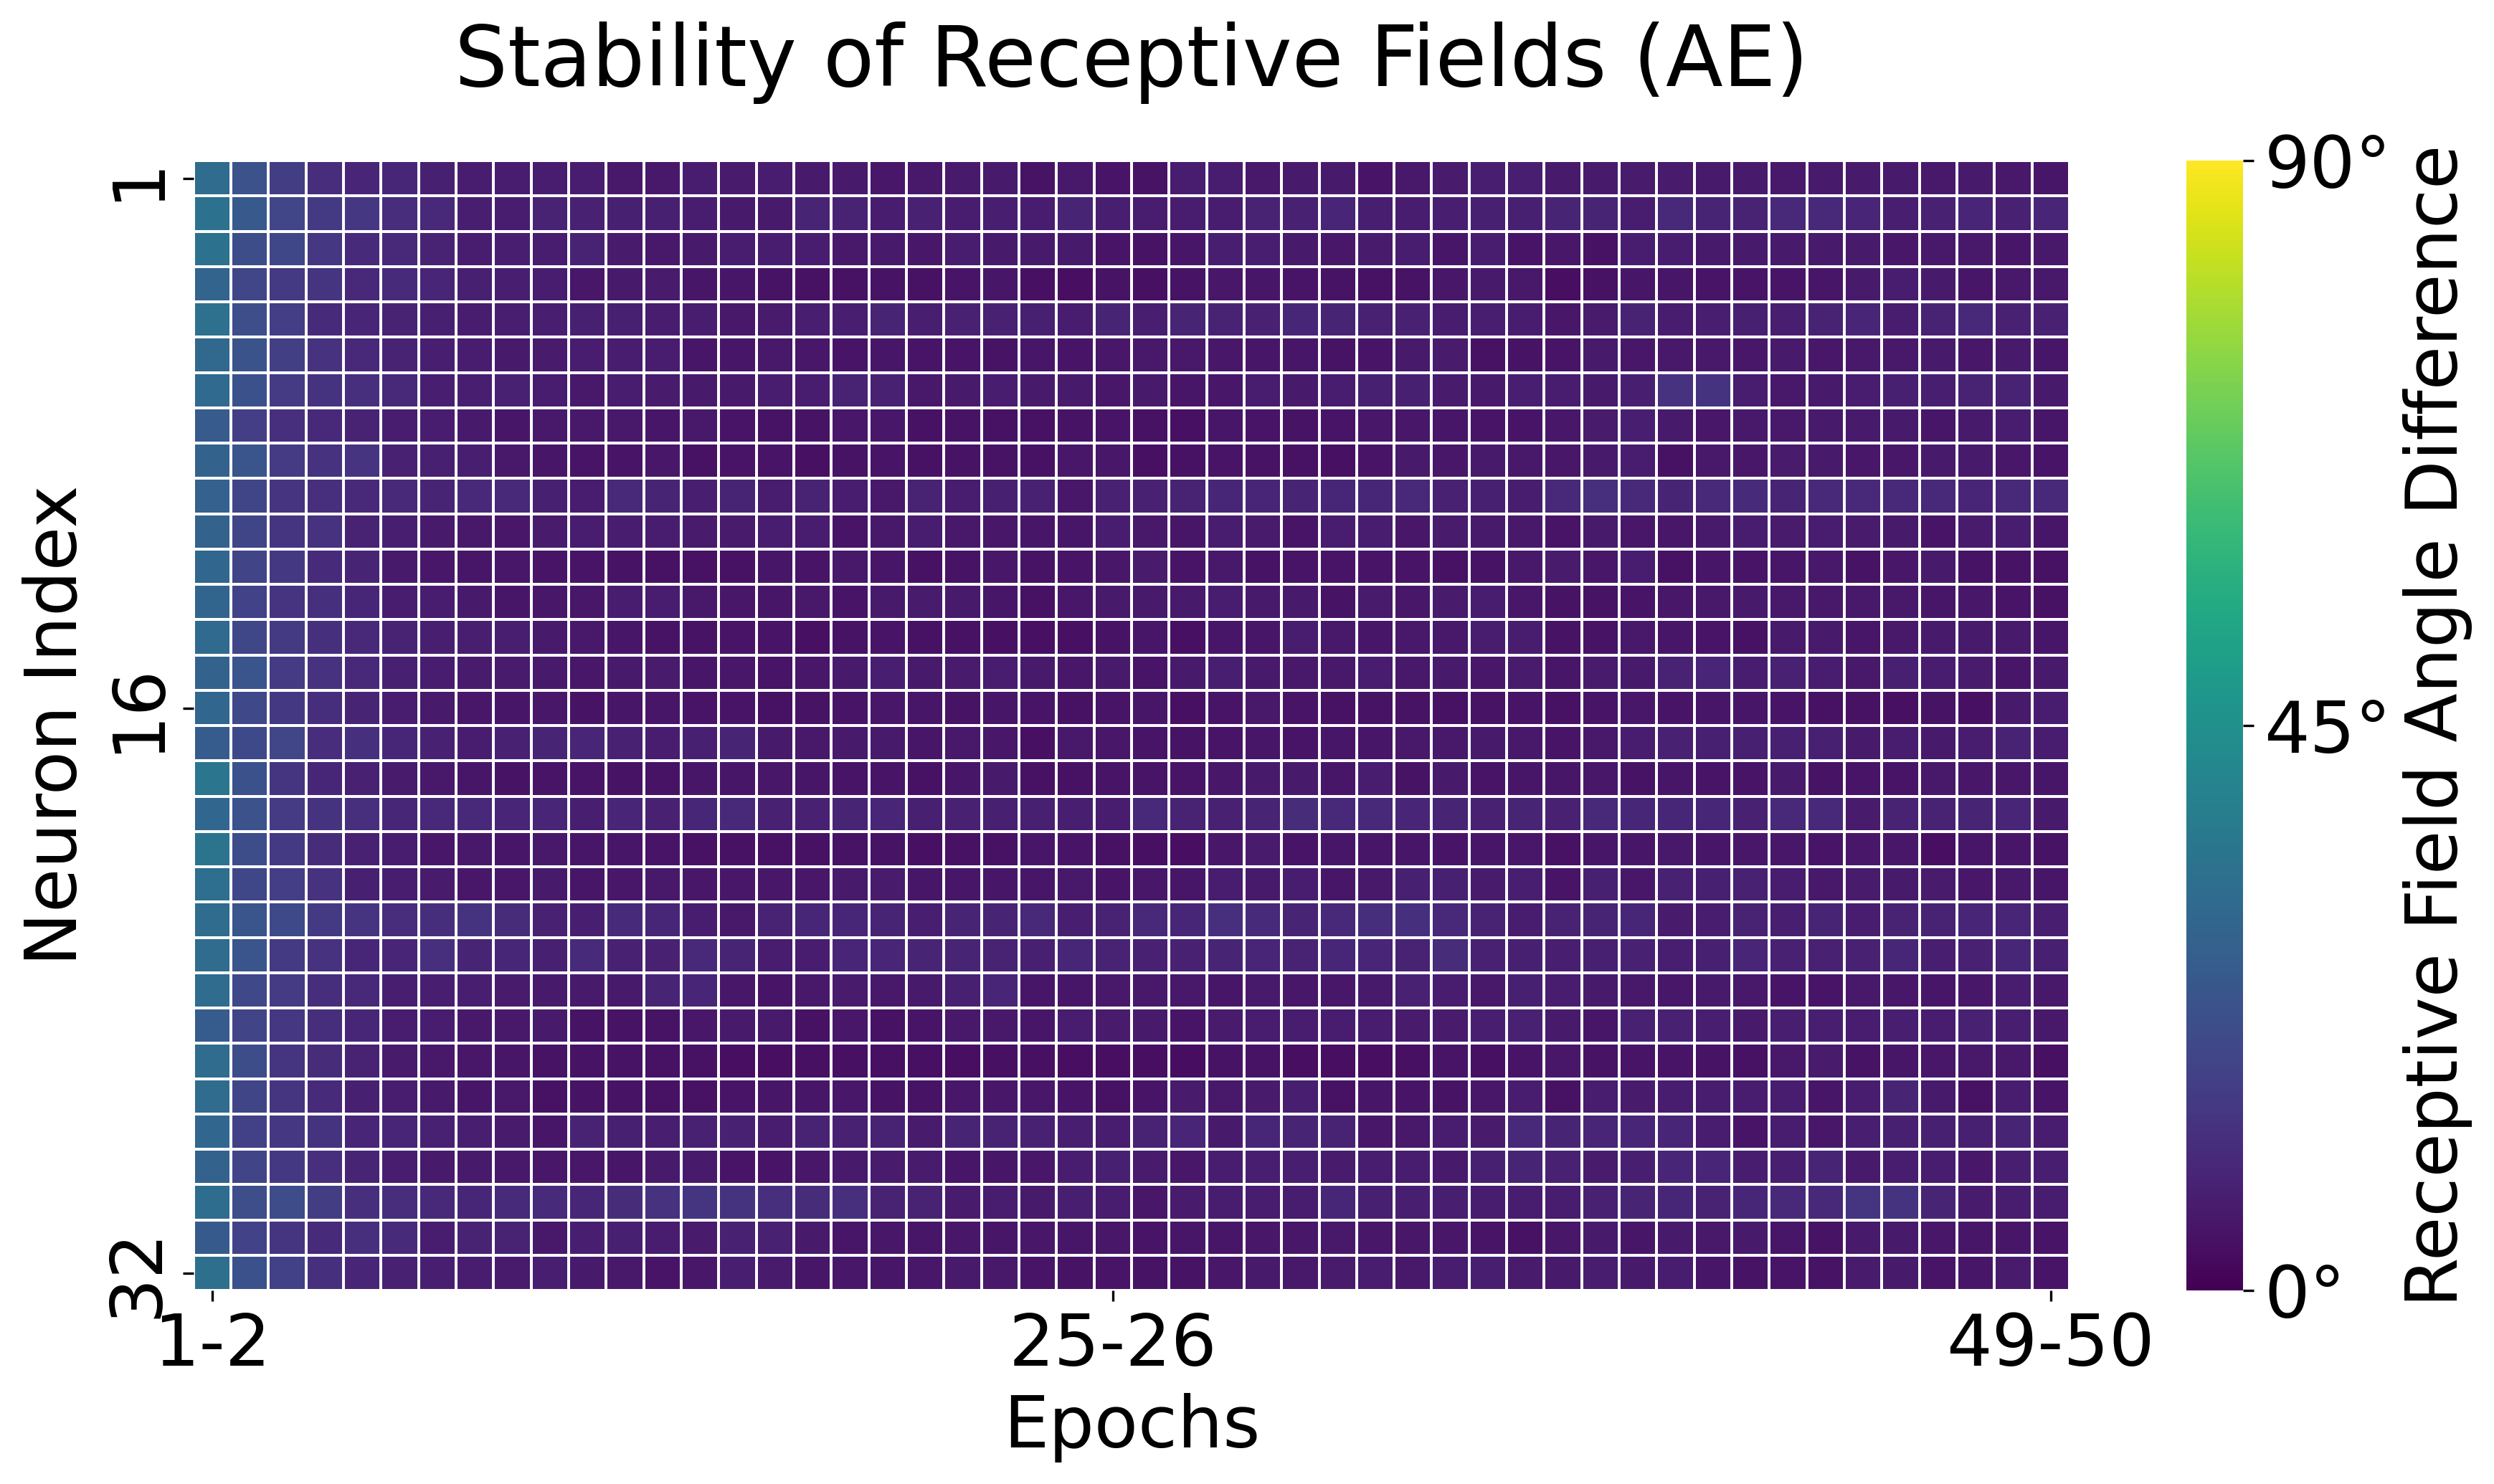

In [175]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    sae_average_angles[:, :50],
    cmap="viridis",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Receptive Field Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Receptive Fields (AE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Neuron Index", fontsize=24)

plt.savefig("Plots_png/sae_stability_of_rfs.png", dpi=300, bbox_inches="tight")
plt.savefig("Plots_svg/sae_stability_of_rfs.svg", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [177]:
highlighted_non_computable_angles = np.load("Saved_Results/dae_average_angles.npy")

In [178]:
for i in range(highlighted_non_computable_angles.shape[0]):
    for j in range(highlighted_non_computable_angles.shape[1] - 1):
        if np.isnan(highlighted_non_computable_angles[i, j]) and not np.isnan(highlighted_non_computable_angles[i, j + 1]):
            highlighted_non_computable_angles[i, j] = 100

In [179]:
mask = highlighted_non_computable_angles == 100
non_computable_cells = np.where(mask, 1, np.nan)

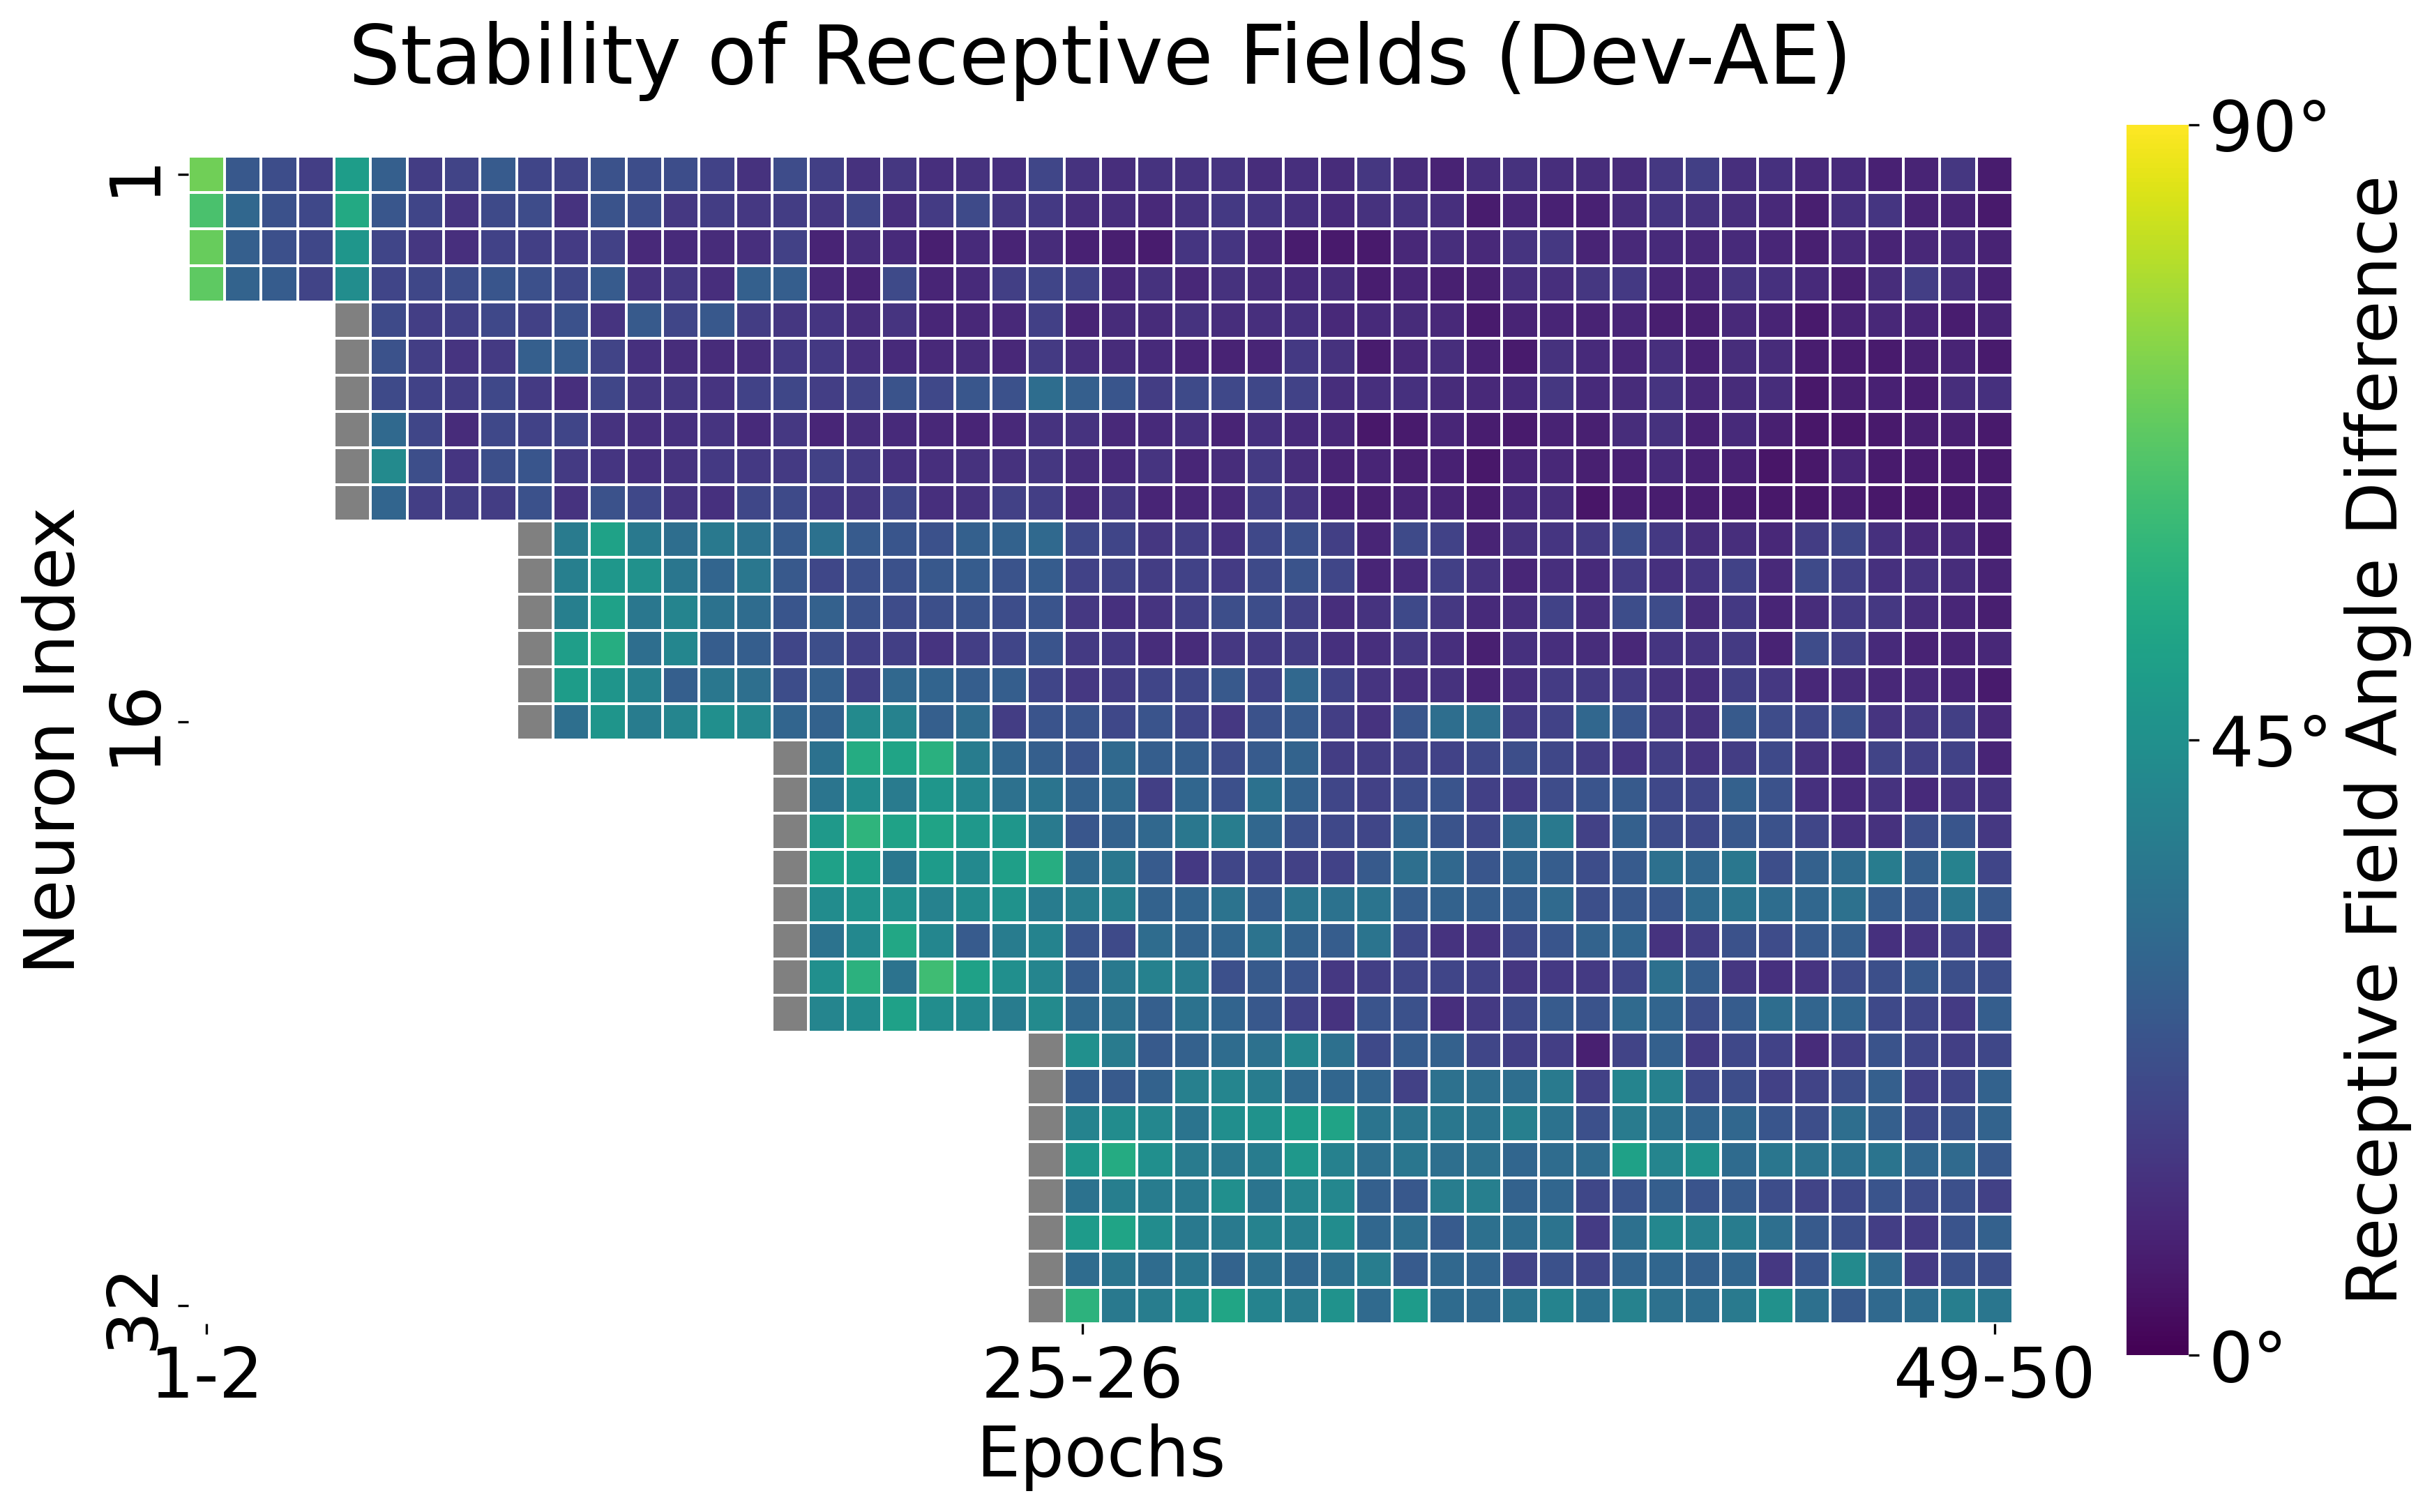

In [181]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    dae_average_angles[:, :50],
    cmap="viridis",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
    square=True,
)

cmap_grey = ListedColormap(['grey'])
sns.heatmap(
    non_computable_cells[:, :50],
    cmap=cmap_grey,
    cbar=False,
    alpha=1,
    linewidths=0.5,
    square=True,
)

# vertical_lines = [4, 9, 16, 23]
# ax.vlines(
#     x=vertical_lines,
#     ymin=0,
#     ymax=dae_average_angles.shape[0],
#     colors='black',
#     linewidths=1,
#     zorder=3,
# )

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Receptive Field Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Receptive Fields (Dev-AE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Neuron Index", fontsize=24)

plt.savefig("Plots_png/dae_stability_of_rfs.png", dpi=300, bbox_inches="tight")
plt.savefig("Plots_svg/dae_stability_of_rfs.svg", bbox_inches="tight")

plt.tight_layout()
plt.show()